In [ ]:
# GENYZ TEAM
# Aleta Edna Jessalyn 
# Angelina Wahyuni 
# Keisya Andretta
# Infall Syafalni

# reusing the nmos and pmos primitives from gLayout

In [8]:
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these

os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'cs.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'cs.gds'))
  display_gds(os.path.join(path,'cs.gds'),path,scale)

from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route
from glayout.primitives.mimcap import mimcap
import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../CSWITCHv2"))

from my_CSWITCH import cswitch, add_cswitch_labels

#comp1 = cswitch(gf180)
#for s in comp1.references:
#    print(s.name)  # This will show 'fet_P', 'fet_N', etc.

#comp1 = add_cswitch_labels(cswitch(gf180), gf180)
#comp1.name = "cswitch"
#comp.write_gds('out_INV.gds')
#display_component(comp1, scale = 0.5, path="../../")

2025-09-17 17:09:37.556 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.4.1", "klayout_version": "0.30.2", "type": "open", "file": "/tmp/gdsfactory/chopper_switch_c$2.gds"}


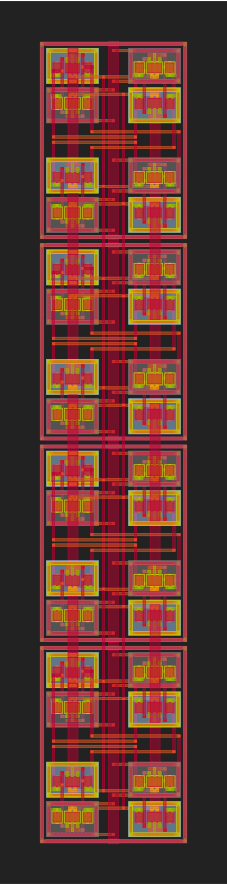

In [9]:
chopper_switch_c = {
    "pdk": gf180,
    "placement" : "vertical",  
    "width": (2,2),
    "length": (0.5,0.5),
    "fingers": (2,2),
    "multipliers": (1,1),
    "dummy_1": (True,True),
    "dummy_2": (True,True),
    "tie_layers1": ("met2","met1"),
    "tie_layers2": ("met2","met1"),
    "sd_rmult":1,
}

top_level = Component(name="chopper_switch_c")
pdk = chopper_switch_c["pdk"]
pdk.activate()

CS1 = cswitch(
    pdk,
    width=chopper_switch_c["width"],
    length=chopper_switch_c["length"],
    fingers=chopper_switch_c["fingers"],
    multipliers=chopper_switch_c["multipliers"],
    dummy_1=chopper_switch_c["dummy_1"],
    dummy_2=chopper_switch_c["dummy_2"],
    tie_layers1=chopper_switch_c["tie_layers1"],
    tie_layers2=chopper_switch_c["tie_layers2"],
    sd_rmult=chopper_switch_c["sd_rmult"],
)

CS1_ref = top_level << CS1
CS2_ref = top_level << CS1
CS3_ref = top_level << CS1
CS4_ref = top_level << CS1

CS1_ref.name = "CS1"
CS2_ref.name = "CS2"
CS3_ref.name = "CS3"
CS4_ref.name = "CS4"
ref_dimensions = evaluate_bbox(CS1_ref)
CS2_ref.movey(- ref_dimensions[1] - pdk.util_max_metal_seperation()*2)
CS3_ref.movey((- ref_dimensions[1] - pdk.util_max_metal_seperation()*2)*2)
CS4_ref.movey((- ref_dimensions[1] - pdk.util_max_metal_seperation()*2)*3)

# VSS Routing CSB
top_level << straight_route(pdk, CS2_ref.ports["VSS_TOP_top_met_N"], CS1_ref.ports["VSS_BOTTOM_top_met_S"])
top_level << straight_route(pdk, CS3_ref.ports["VSS_TOP_top_met_N"], CS2_ref.ports["VSS_BOTTOM_top_met_S"])
top_level << straight_route(pdk, CS4_ref.ports["VSS_TOP_top_met_N"], CS3_ref.ports["VSS_BOTTOM_top_met_S"])

# Left VDD Routing CSB
top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPL_top_met_N"], CS1_ref.ports["VDD_BOTTOML_top_met_S"])
top_level << straight_route(pdk, CS3_ref.ports["VDD_TOPL_top_met_N"], CS2_ref.ports["VDD_BOTTOML_top_met_S"])
top_level << straight_route(pdk, CS4_ref.ports["VDD_TOPL_top_met_N"], CS3_ref.ports["VDD_BOTTOML_top_met_S"])

# Right VDD Routing CSB
top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPR_top_met_N"], CS1_ref.ports["VDD_BOTTOMR_top_met_S"])
top_level << straight_route(pdk, CS3_ref.ports["VDD_TOPR_top_met_N"], CS2_ref.ports["VDD_BOTTOMR_top_met_S"])
top_level << straight_route(pdk, CS4_ref.ports["VDD_TOPR_top_met_N"], CS3_ref.ports["VDD_BOTTOMR_top_met_S"])

# CLK Routing 
top_level << straight_route(pdk, CS2_ref.ports["CLK_TOP_top_met_N"], CS1_ref.ports["CLK_BOTTOM_top_met_S"])
top_level << straight_route(pdk, CS3_ref.ports["CLK_TOP_top_met_N"], CS2_ref.ports["CLK_BOTTOM_top_met_S"])
top_level << straight_route(pdk, CS4_ref.ports["CLK_TOP_top_met_N"], CS3_ref.ports["CLK_BOTTOM_top_met_S"])

# CLK_inv Routing
top_level << straight_route(pdk, CS2_ref.ports["CLKINV_TOP_top_met_N"], CS1_ref.ports["CLKINV_BOTTOM_top_met_S"])
top_level << straight_route(pdk, CS3_ref.ports["CLKINV_TOP_top_met_N"], CS2_ref.ports["CLKINV_BOTTOM_top_met_S"])
top_level << straight_route(pdk, CS4_ref.ports["CLKINV_TOP_top_met_N"], CS3_ref.ports["CLKINV_BOTTOM_top_met_S"])

top_level.show()
display_component(top_level, scale=0.5, path="../")

2025-09-17 17:09:40.109 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.4.1", "klayout_version": "0.30.2", "type": "reload", "file": "/tmp/gdsfactory/chopper_switch_c$2.gds"}


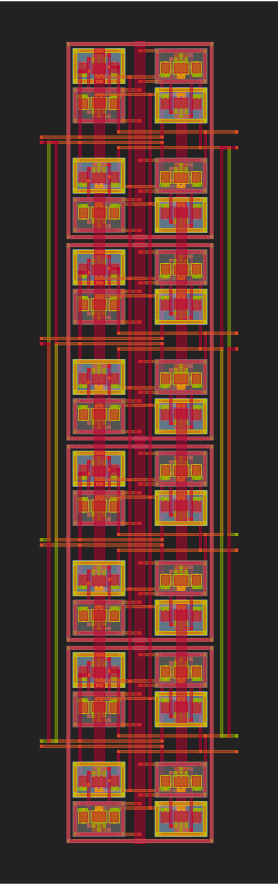

In [10]:
# Input
viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
viam1m2 = via_stack(pdk, "met1", "met2", centered=True)

vinp1_via = top_level << viam2m3
vinn1_via = top_level << viam2m3
vinp3h_via = top_level << viam1m2

vinp2_via = top_level << viam2m3
vinn2_via = top_level << viam2m3
vinp4h_via = top_level << viam1m2

vinn3_via = top_level << viam2m3
vinn1h_via = top_level << viam2m3
vinp3_via = top_level << viam1m2

vinn4_via = top_level << viam2m3
vinn2h_via = top_level << viam2m3
vinp4_via = top_level << viam1m2


vinp1_via.move(CS1_ref.ports["INP_bottom_met_W"].center).movex(-7.5) #port INP1
vinn1_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-7.5) #port INN1
vinp3h_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-6)

vinp2_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-7.5) #port INP2
vinn2_via.move(CS2_ref.ports["INN_bottom_met_W"].center).movex(-7.5) #port INN2
vinp4h_via.move(CS2_ref.ports["INN_bottom_met_W"].center).movex(-4.5)

vinn3_via.move(CS3_ref.ports["INN_bottom_met_W"].center).movex(-7.5) #port INN3
vinn1h_via.move(CS3_ref.ports["INP_bottom_met_W"].center).movex(-4.5)
vinp3_via.move(CS3_ref.ports["INP_bottom_met_W"].center).movex(-7.5) #port INP3

vinn4_via.move(CS4_ref.ports["INN_bottom_met_W"].center).movex(-7.5) #port INN4
vinn2h_via.move(CS4_ref.ports["INP_bottom_met_W"].center).movex(-6)
vinp4_via.move(CS4_ref.ports["INP_bottom_met_W"].center).movex(-7.5) #port INP4

#CS1 & CS3
top_level << straight_route(pdk, CS1_ref.ports["INP_bottom_met_W"], vinp1_via.ports["bottom_met_E"])
top_level << straight_route(pdk, CS3_ref.ports["INN_bottom_met_W"], vinn3_via.ports["bottom_met_E"]) 
top_level << straight_route(pdk, CS1_ref.ports["INN_bottom_met_W"], vinp3h_via.ports["top_met_E"])
top_level << straight_route(pdk, CS3_ref.ports["INP_bottom_met_W"], vinn1h_via.ports["bottom_met_E"]) 
top_level << L_route(pdk, vinp3_via.ports["bottom_met_E"], vinp3h_via.ports["bottom_met_S"])
top_level << L_route(pdk, vinn1h_via.ports["top_met_S"], vinn1_via.ports["top_met_W"])

#CS2 & CS4
top_level << straight_route(pdk, CS2_ref.ports["INP_bottom_met_W"], vinp2_via.ports["bottom_met_E"]) 
top_level << straight_route(pdk, CS4_ref.ports["INN_bottom_met_W"], vinn4_via.ports["bottom_met_E"])
top_level << straight_route(pdk, CS2_ref.ports["INN_bottom_met_W"], vinp4h_via.ports["top_met_E"])
top_level << straight_route(pdk, CS4_ref.ports["INP_bottom_met_W"], vinn2h_via.ports["bottom_met_E"]) 
top_level << L_route(pdk, vinp4_via.ports["bottom_met_E"], vinp4h_via.ports["bottom_met_S"]) 
top_level << L_route(pdk, vinn2_via.ports["top_met_W"], vinn2h_via.ports["top_met_S"])

voutp1_via = top_level << viam2m3
voutn1_via = top_level << viam2m3
voutp3h_via = top_level << viam1m2

voutp2_via = top_level << viam2m3
voutn2_via = top_level << viam2m3
voutp4h_via = top_level << viam1m2

voutn3_via = top_level << viam2m3
voutn1h_via = top_level << viam2m3
voutp3_via = top_level << viam1m2

voutn4_via = top_level << viam2m3
voutn2h_via = top_level << viam2m3
voutp4_via = top_level << viam1m2

voutp1_via.move(CS1_ref.ports["OUTP_bottom_met_W"].center).movex(6.5) #port OUTP1
voutn1_via.move(CS1_ref.ports["OUTN_bottom_met_W"].center).movex(7.5) #port OUTN1
voutp3h_via.move(CS1_ref.ports["OUTN_bottom_met_W"].center).movex(6)

voutp2_via.move(CS2_ref.ports["OUTP_bottom_met_W"].center).movex(6.5) #port OUTP2
voutn2_via.move(CS2_ref.ports["OUTN_bottom_met_W"].center).movex(7.5) #port OUTN2
voutp4h_via.move(CS2_ref.ports["OUTN_bottom_met_W"].center).movex(4.5)

voutn3_via.move(CS3_ref.ports["OUTN_bottom_met_W"].center).movex(7.5) #port OUTN3
voutn1h_via.move(CS3_ref.ports["OUTP_bottom_met_W"].center).movex(3.5)
voutp3_via.move(CS3_ref.ports["OUTP_bottom_met_W"].center).movex(6.5) #port OUTP3

voutn4_via.move(CS4_ref.ports["OUTN_bottom_met_W"].center).movex(7.5) #port OUTN4
voutn2h_via.move(CS4_ref.ports["OUTP_bottom_met_W"].center).movex(5)
voutp4_via.move(CS4_ref.ports["OUTP_bottom_met_W"].center).movex(6.5) #port OUTP4

#CS1 & CS3
top_level << straight_route(pdk, CS1_ref.ports["OUTP_bottom_met_W"], voutp1_via.ports["bottom_met_E"])
top_level << straight_route(pdk, CS3_ref.ports["OUTN_bottom_met_W"], voutn3_via.ports["bottom_met_E"]) 
top_level << straight_route(pdk, CS1_ref.ports["OUTN_bottom_met_W"], voutp3h_via.ports["top_met_E"])
top_level << straight_route(pdk, CS3_ref.ports["OUTP_bottom_met_W"], voutn1h_via.ports["bottom_met_E"]) 
top_level << L_route(pdk, voutp3_via.ports["bottom_met_E"], voutp3h_via.ports["bottom_met_S"])
top_level << L_route(pdk, voutn1h_via.ports["top_met_S"], voutn1_via.ports["top_met_W"])

#CS2 & CS4
top_level << straight_route(pdk, CS2_ref.ports["OUTP_bottom_met_W"], voutp2_via.ports["bottom_met_E"]) 
top_level << straight_route(pdk, CS4_ref.ports["OUTN_bottom_met_W"], voutn4_via.ports["bottom_met_E"])
top_level << straight_route(pdk, CS2_ref.ports["OUTN_bottom_met_W"], voutp4h_via.ports["top_met_E"])
top_level << straight_route(pdk, CS4_ref.ports["OUTP_bottom_met_W"], voutn2h_via.ports["bottom_met_E"]) 
top_level << L_route(pdk, voutp4_via.ports["bottom_met_E"], voutp4h_via.ports["bottom_met_S"]) 
top_level << L_route(pdk, voutn2_via.ports["top_met_W"], voutn2h_via.ports["top_met_S"])

top_level.show()
display_component(top_level, scale = 0.5,path="../")

2025-09-17 17:09:42.441 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.4.1", "klayout_version": "0.30.2", "type": "open", "file": "/tmp/gdsfactory/chopper_switch_c2.gds"}


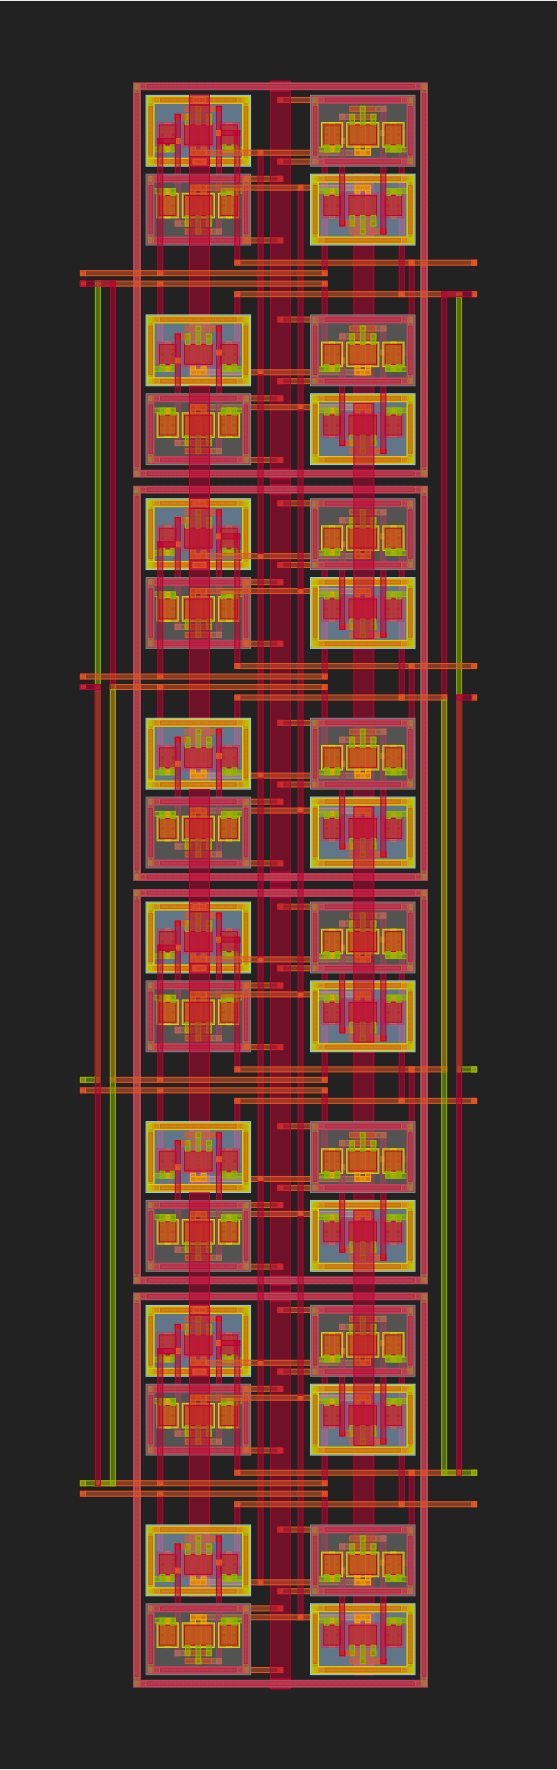

In [11]:
top_level.add_ports(CS1_ref.get_ports_list(), prefix="CS1_")
top_level.add_ports(CS2_ref.get_ports_list(), prefix="CS2_")
top_level.add_ports(CS3_ref.get_ports_list(), prefix="CS3_")
top_level.add_ports(CS4_ref.get_ports_list(), prefix="CS4_")

top_level.add_ports(vinp1_via.get_ports_list(), prefix="VINP1_")
top_level.add_ports(vinn1_via.get_ports_list(), prefix="VINN1_")
top_level.add_ports(vinp2_via.get_ports_list(), prefix="VINP2_")
top_level.add_ports(vinn2_via.get_ports_list(), prefix="VINN2_")
top_level.add_ports(vinp3_via.get_ports_list(), prefix="VINP3_")
top_level.add_ports(vinn3_via.get_ports_list(), prefix="VINN3_")
top_level.add_ports(vinp4_via.get_ports_list(), prefix="VINP4_")
top_level.add_ports(vinn4_via.get_ports_list(), prefix="VINN4_")

top_level.add_ports(voutp1_via.get_ports_list(), prefix="VOUTP1_")
top_level.add_ports(voutn1_via.get_ports_list(), prefix="VOUTN1_")
top_level.add_ports(voutp2_via.get_ports_list(), prefix="VOUTP2_")
top_level.add_ports(voutn2_via.get_ports_list(), prefix="VOUTN2_")
top_level.add_ports(voutp3_via.get_ports_list(), prefix="VOUTP3_")
top_level.add_ports(voutn3_via.get_ports_list(), prefix="VOUTN3_")
top_level.add_ports(voutp4_via.get_ports_list(), prefix="VOUTP4_")
top_level.add_ports(voutn4_via.get_ports_list(), prefix="VOUTN4_")

component = component_snap_to_grid(rename_ports_by_orientation(top_level))
component.show()
display_component(top_level, scale =1,path="../")

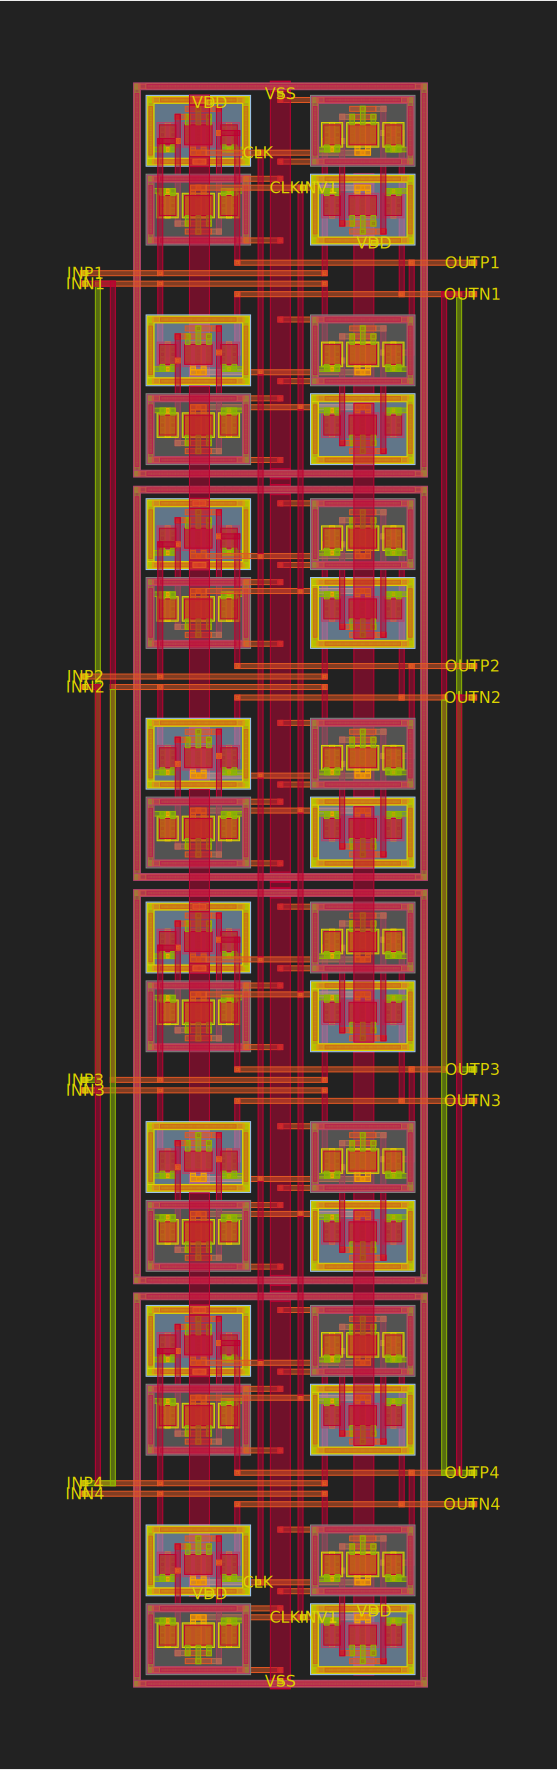

In [12]:
psize=(0.5,0.5)
# list that will contain all port/comp info
move_info = list()
# create labels and append to info list

inputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputp1label.add_label(text="INP1",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputp1label,component.ports["VINP1_top_met_E"], None))
inputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputp2label.add_label(text="INP2",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputp2label,component.ports["VINP2_top_met_E"], None))
inputp3label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputp3label.add_label(text="INP3",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputp3label,component.ports["VINP3_top_met_E"], None))
inputp4label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputp4label.add_label(text="INP4",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputp4label,component.ports["VINP4_top_met_E"], None))

inputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputn1label.add_label(text="INN1",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputn1label,component.ports["VINN1_top_met_E"], None))
inputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputn2label.add_label(text="INN2",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputn2label,component.ports["VINN2_top_met_E"], None))
inputn3label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputn3label.add_label(text="INN3",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputn3label,component.ports["VINN3_top_met_E"], None))
inputn4label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputn4label.add_label(text="INN4",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputn4label,component.ports["VINN4_top_met_E"], None))

outputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputp1label.add_label(text="OUTP1",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputp1label,component.ports["VOUTP1_top_met_W"],None))
outputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputp2label.add_label(text="OUTP2",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputp2label,component.ports["VOUTP2_top_met_W"],None))
outputp3label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputp3label.add_label(text="OUTP3",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputp3label,component.ports["VOUTP3_top_met_W"],None))
outputp4label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputp4label.add_label(text="OUTP4",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputp4label,component.ports["VOUTP4_top_met_W"],None))

outputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputn1label.add_label(text="OUTN1",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputn1label,component.ports["VOUTN1_top_met_W"],None))
outputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputn2label.add_label(text="OUTN2",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputn2label,component.ports["VOUTN2_top_met_W"],None))
outputn3label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputn3label.add_label(text="OUTN3",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputn3label,component.ports["VOUTN3_top_met_W"],None))
outputn4label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputn4label.add_label(text="OUTN4",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputn4label,component.ports["VOUTN4_top_met_W"],None))

vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vsslabel,component.ports["CS1_VSS_TOP_top_met_S"],None))
move_info.append((vsslabel,component.ports["CS4_VSS_BOTTOM_top_met_N"],None))

vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddlabel,component.ports["CS1_VDD_TOPL_top_met_E"],None))
move_info.append((vddlabel,component.ports["CS1_VDD_TOPR_top_met_E"],None))
move_info.append((vddlabel,component.ports["CS4_VDD_BOTTOML_top_met_E"],None))
move_info.append((vddlabel,component.ports["CS4_VDD_BOTTOMR_top_met_E"],None))

clklabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clklabel.add_label(text="CLK",layer=pdk.get_glayer("met3_pin"))
move_info.append((clklabel,component.ports["CS1_CLK_TOP_top_met_W"], None))
move_info.append((clklabel,component.ports["CS4_CLK_BOTTOM_top_met_W"], None))

clkinvlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clkinvlabel.add_label(text="CLKINV1",layer=pdk.get_glayer("met3_pin"))
move_info.append((clkinvlabel,component.ports["CS1_CLKINV_TOP_top_met_E"], None))
move_info.append((clkinvlabel,component.ports["CS4_CLKINV_BOTTOM_top_met_E"], None))

for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        top_level.add(compref)

display_component(top_level, scale =1,path="../")

In [13]:
comps = top_level.flatten()
comps.name="cswitchc"
drc_result = gf180.drc_magic(comps, comps.name)

2025-09-17 17:09:44.098 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmppc_t298l/cswitchc$1.gds'


using default pdk_root
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmppc_t298l/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "cswitchc$1".
[INFO]: Loading cswitchc$1

Loading DRC CIF style.
No e

In [14]:
inv_code_string = """
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../CSWITCHv2"))

from my_CSWITCH import cswitch

def add_cswitchc_labels(
    cswitchc_in: Component,
    pdk: MappedPDK,
    ) -> Component:
    
    cswitchc_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    # INPUT
    inputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputp1label.add_label(text="INP1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputp1label,cswitchc_in.ports["VINP1_top_met_E"], None))
    inputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputp2label.add_label(text="INP2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputp2label,cswitchc_in.ports["VINP2_top_met_E"], None))
    inputp3label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputp3label.add_label(text="INP3",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputp3label,cswitchc_in.ports["VINP3_top_met_E"], None))
    inputp4label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputp4label.add_label(text="INP4",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputp4label,cswitchc_in.ports["VINP4_top_met_E"], None))

    inputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputn1label.add_label(text="INN1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputn1label,cswitchc_in.ports["VINN1_top_met_E"], None))
    inputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputn2label.add_label(text="INN2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputn2label,cswitchc_in.ports["VINN2_top_met_E"], None))
    inputn3label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputn3label.add_label(text="INN3",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputn3label,cswitchc_in.ports["VINN3_top_met_E"], None))
    inputn4label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputn4label.add_label(text="INN4",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputn4label,cswitchc_in.ports["VINN4_top_met_E"], None))

    outputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputp1label.add_label(text="OUTP1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputp1label,cswitchc_in.ports["VOUTP1_top_met_W"],None))
    outputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputp2label.add_label(text="OUTP2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputp2label,cswitchc_in.ports["VOUTP2_top_met_W"],None))
    outputp3label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputp3label.add_label(text="OUTP3",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputp3label,cswitchc_in.ports["VOUTP3_top_met_W"],None))
    outputp4label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputp4label.add_label(text="OUTP4",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputp4label,cswitchc_in.ports["VOUTP4_top_met_W"],None))

    outputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputn1label.add_label(text="OUTN1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputn1label,cswitchc_in.ports["VOUTN1_top_met_W"],None))
    outputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputn2label.add_label(text="OUTN2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputn2label,cswitchc_in.ports["VOUTN2_top_met_W"],None))
    outputn3label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputn3label.add_label(text="OUTN3",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputn3label,cswitchc_in.ports["VOUTN3_top_met_W"],None))
    outputn4label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputn4label.add_label(text="OUTN4",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputn4label,cswitchc_in.ports["VOUTN4_top_met_W"],None))

    vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vsslabel,cswitchc_in.ports["CS1_VSS_TOP_top_met_S"],None))
    move_info.append((vsslabel,cswitchc_in.ports["CS4_VSS_BOTTOM_top_met_N"],None))

    vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddlabel,cswitchc_in.ports["CS1_VDD_TOPL_top_met_E"],None))
    move_info.append((vddlabel,cswitchc_in.ports["CS1_VDD_TOPR_top_met_E"],None))
    move_info.append((vddlabel,cswitchc_in.ports["CS4_VDD_BOTTOML_top_met_E"],None))
    move_info.append((vddlabel,cswitchc_in.ports["CS4_VDD_BOTTOMR_top_met_E"],None))

    clklabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clklabel.add_label(text="CLK",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clklabel,cswitchc_in.ports["CS1_CLK_TOP_top_met_W"], None))
    move_info.append((clklabel,cswitchc_in.ports["CS4_CLK_BOTTOM_top_met_W"], None))

    clkinvlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clkinvlabel.add_label(text="CLKINV1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clkinvlabel,cswitchc_in.ports["CS1_CLKINV_TOP_top_met_E"], None))
    move_info.append((clkinvlabel,cswitchc_in.ports["CS4_CLKINV_BOTTOM_top_met_E"], None))

    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            cswitchb_in.add(compref)
    
    return cswitchc_in.flatten()

def cswitchc(
        pdk: MappedPDK,
        width: tuple[float,float] = (2,2),
        length: tuple[float,float] = (0.5,0.5),
        fingers: tuple[int,int] = (2,2),
        multipliers: tuple[int,int] = (1,1),
        dummy_1: tuple[bool,bool] = (True,True),
        dummy_2: tuple[bool,bool] = (True,True),
        tie_layers1: tuple[str,str] = ("met2","met1"),
        tie_layers2: tuple[str,str] = ("met2","met1"),
        sd_rmult: int=1,
        **kwargs
        ) -> Component:

    pdk.activate()
    
    #top level component
    top_level = Component(name="cswitchc")

    CS1 = cswitch(pdk,(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))

    CS1_ref = top_level << CS1
    CS2_ref = top_level << CS1
    CS3_ref = top_level << CS1
    CS4_ref = top_level << CS1

    CS1_ref.name = "CS1"
    CS2_ref.name = "CS2"
    CS3_ref.name = "CS3"
    CS4_ref.name = "CS4"
    ref_dimensions = evaluate_bbox(CS1_ref)
    CS2_ref.movey(- ref_dimensions[1] - pdk.util_max_metal_seperation()*2)
    CS3_ref.movey((- ref_dimensions[1] - pdk.util_max_metal_seperation()*2)*2)
    CS4_ref.movey((- ref_dimensions[1] - pdk.util_max_metal_seperation()*2)*3)

    # VSS Routing CSB
    top_level << straight_route(pdk, CS2_ref.ports["VSS_TOP_top_met_N"], CS1_ref.ports["VSS_BOTTOM_top_met_S"])
    top_level << straight_route(pdk, CS3_ref.ports["VSS_TOP_top_met_N"], CS2_ref.ports["VSS_BOTTOM_top_met_S"])
    top_level << straight_route(pdk, CS4_ref.ports["VSS_TOP_top_met_N"], CS3_ref.ports["VSS_BOTTOM_top_met_S"])

    # Left VDD Routing CSB
    top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPL_top_met_N"], CS1_ref.ports["VDD_BOTTOML_top_met_S"])
    top_level << straight_route(pdk, CS3_ref.ports["VDD_TOPL_top_met_N"], CS2_ref.ports["VDD_BOTTOML_top_met_S"])
    top_level << straight_route(pdk, CS4_ref.ports["VDD_TOPL_top_met_N"], CS3_ref.ports["VDD_BOTTOML_top_met_S"])

    # Right VDD Routing CSB
    top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPR_top_met_N"], CS1_ref.ports["VDD_BOTTOMR_top_met_S"])
    top_level << straight_route(pdk, CS3_ref.ports["VDD_TOPR_top_met_N"], CS2_ref.ports["VDD_BOTTOMR_top_met_S"])
    top_level << straight_route(pdk, CS4_ref.ports["VDD_TOPR_top_met_N"], CS3_ref.ports["VDD_BOTTOMR_top_met_S"])

    # CLK Routing 
    top_level << straight_route(pdk, CS2_ref.ports["CLK_TOP_top_met_N"], CS1_ref.ports["CLK_BOTTOM_top_met_S"])
    top_level << straight_route(pdk, CS3_ref.ports["CLK_TOP_top_met_N"], CS2_ref.ports["CLK_BOTTOM_top_met_S"])
    top_level << straight_route(pdk, CS4_ref.ports["CLK_TOP_top_met_N"], CS3_ref.ports["CLK_BOTTOM_top_met_S"])

    # CLK_inv Routing
    top_level << straight_route(pdk, CS2_ref.ports["CLKINV_TOP_top_met_N"], CS1_ref.ports["CLKINV_BOTTOM_top_met_S"])
    top_level << straight_route(pdk, CS3_ref.ports["CLKINV_TOP_top_met_N"], CS2_ref.ports["CLKINV_BOTTOM_top_met_S"])
    top_level << straight_route(pdk, CS4_ref.ports["CLKINV_TOP_top_met_N"], CS3_ref.ports["CLKINV_BOTTOM_top_met_S"])

    viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.
    
    #input routes
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
    viam1m2 = via_stack(pdk, "met1", "met2", centered=True)
    vinp1_via = top_level << viam2m3
    vinn1_via = top_level << viam2m3
    vinp3h_via = top_level << viam1m2

    vinp2_via = top_level << viam2m3
    vinn2_via = top_level << viam2m3
    vinp4h_via = top_level << viam1m2

    vinn3_via = top_level << viam2m3
    vinn1h_via = top_level << viam2m3
    vinp3_via = top_level << viam1m2

    vinn4_via = top_level << viam2m3
    vinn2h_via = top_level << viam2m3
    vinp4_via = top_level << viam1m2

    vinp1_via.move(CS1_ref.ports["INP_bottom_met_W"].center).movex(-7.5) #port INP1
    vinn1_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-7.5) #port INN1
    vinp3h_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-6)

    vinp2_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-7.5) #port INP2
    vinn2_via.move(CS2_ref.ports["INN_bottom_met_W"].center).movex(-7.5) #port INN2
    vinp4h_via.move(CS2_ref.ports["INN_bottom_met_W"].center).movex(-4.5)

    vinn3_via.move(CS3_ref.ports["INN_bottom_met_W"].center).movex(-7.5) #port INN3
    vinn1h_via.move(CS3_ref.ports["INP_bottom_met_W"].center).movex(-4.5)
    vinp3_via.move(CS3_ref.ports["INP_bottom_met_W"].center).movex(-7.5) #port INP3

    vinn4_via.move(CS4_ref.ports["INN_bottom_met_W"].center).movex(-7.5) #port INN4
    vinn2h_via.move(CS4_ref.ports["INP_bottom_met_W"].center).movex(-6)
    vinp4_via.move(CS4_ref.ports["INP_bottom_met_W"].center).movex(-7.5) #port INP4

    #CS1 & CS3
    top_level << straight_route(pdk, CS1_ref.ports["INP_bottom_met_W"], vinp1_via.ports["bottom_met_E"])
    top_level << straight_route(pdk, CS3_ref.ports["INN_bottom_met_W"], vinn3_via.ports["bottom_met_E"]) 
    top_level << straight_route(pdk, CS1_ref.ports["INN_bottom_met_W"], vinp3h_via.ports["top_met_E"])
    top_level << straight_route(pdk, CS3_ref.ports["INP_bottom_met_W"], vinn1h_via.ports["bottom_met_E"]) 
    top_level << L_route(pdk, vinp3_via.ports["bottom_met_E"], vinp3h_via.ports["bottom_met_S"])
    top_level << L_route(pdk, vinn1h_via.ports["top_met_S"], vinn1_via.ports["top_met_W"])

    #CS2 & CS4
    top_level << straight_route(pdk, CS2_ref.ports["INP_bottom_met_W"], vinp2_via.ports["bottom_met_E"]) 
    top_level << straight_route(pdk, CS4_ref.ports["INN_bottom_met_W"], vinn4_via.ports["bottom_met_E"])
    top_level << straight_route(pdk, CS2_ref.ports["INN_bottom_met_W"], vinp4h_via.ports["top_met_E"])
    top_level << straight_route(pdk, CS4_ref.ports["INP_bottom_met_W"], vinn2h_via.ports["bottom_met_E"]) 
    top_level << L_route(pdk, vinp4_via.ports["bottom_met_E"], vinp4h_via.ports["bottom_met_S"]) 
    top_level << L_route(pdk, vinn2_via.ports["top_met_W"], vinn2h_via.ports["top_met_S"])

    voutp1_via = top_level << viam2m3
    voutn1_via = top_level << viam2m3
    voutp3h_via = top_level << viam1m2

    voutp2_via = top_level << viam2m3
    voutn2_via = top_level << viam2m3
    voutp4h_via = top_level << viam1m2

    voutn3_via = top_level << viam2m3
    voutn1h_via = top_level << viam2m3
    voutp3_via = top_level << viam1m2

    voutn4_via = top_level << viam2m3
    voutn2h_via = top_level << viam2m3
    voutp4_via = top_level << viam1m2

    voutp1_via.move(CS1_ref.ports["OUTP_bottom_met_W"].center).movex(6.5) #port OUTP1
    voutn1_via.move(CS1_ref.ports["OUTN_bottom_met_W"].center).movex(7.5) #port OUTN1
    voutp3h_via.move(CS1_ref.ports["OUTN_bottom_met_W"].center).movex(6)

    voutp2_via.move(CS2_ref.ports["OUTP_bottom_met_W"].center).movex(6.5) #port OUTP2
    voutn2_via.move(CS2_ref.ports["OUTN_bottom_met_W"].center).movex(7.5) #port OUTN2
    voutp4h_via.move(CS2_ref.ports["OUTN_bottom_met_W"].center).movex(4.5)

    voutn3_via.move(CS3_ref.ports["OUTN_bottom_met_W"].center).movex(7.5) #port OUTN3
    voutn1h_via.move(CS3_ref.ports["OUTP_bottom_met_W"].center).movex(3.5)
    voutp3_via.move(CS3_ref.ports["OUTP_bottom_met_W"].center).movex(6.5) #port OUTP3

    voutn4_via.move(CS4_ref.ports["OUTN_bottom_met_W"].center).movex(7.5) #port OUTN4
    voutn2h_via.move(CS4_ref.ports["OUTP_bottom_met_W"].center).movex(5)
    voutp4_via.move(CS4_ref.ports["OUTP_bottom_met_W"].center).movex(6.5) #port OUTP4

    #CS1 & CS3
    top_level << straight_route(pdk, CS1_ref.ports["OUTP_bottom_met_W"], voutp1_via.ports["bottom_met_E"])
    top_level << straight_route(pdk, CS3_ref.ports["OUTN_bottom_met_W"], voutn3_via.ports["bottom_met_E"]) 
    top_level << straight_route(pdk, CS1_ref.ports["OUTN_bottom_met_W"], voutp3h_via.ports["top_met_E"])
    top_level << straight_route(pdk, CS3_ref.ports["OUTP_bottom_met_W"], voutn1h_via.ports["bottom_met_E"]) 
    top_level << L_route(pdk, voutp3_via.ports["bottom_met_E"], voutp3h_via.ports["bottom_met_S"])
    top_level << L_route(pdk, voutn1h_via.ports["top_met_S"], voutn1_via.ports["top_met_W"])

    #CS2 & CS4
    top_level << straight_route(pdk, CS2_ref.ports["OUTP_bottom_met_W"], voutp2_via.ports["bottom_met_E"]) 
    top_level << straight_route(pdk, CS4_ref.ports["OUTN_bottom_met_W"], voutn4_via.ports["bottom_met_E"])
    top_level << straight_route(pdk, CS2_ref.ports["OUTN_bottom_met_W"], voutp4h_via.ports["top_met_E"])
    top_level << straight_route(pdk, CS4_ref.ports["OUTP_bottom_met_W"], voutn2h_via.ports["bottom_met_E"]) 
    top_level << L_route(pdk, voutp4_via.ports["bottom_met_E"], voutp4h_via.ports["bottom_met_S"]) 
    top_level << L_route(pdk, voutn2_via.ports["top_met_W"], voutn2h_via.ports["top_met_S"])

    top_level.add_ports(CS1_ref.get_ports_list(), prefix="CS1_")
    top_level.add_ports(CS2_ref.get_ports_list(), prefix="CS2_")
    top_level.add_ports(CS3_ref.get_ports_list(), prefix="CS3_")
    top_level.add_ports(CS4_ref.get_ports_list(), prefix="CS4_")

    top_level.add_ports(vinp1_via.get_ports_list(), prefix="VINP1_")
    top_level.add_ports(vinn1_via.get_ports_list(), prefix="VINN1_")
    top_level.add_ports(vinp2_via.get_ports_list(), prefix="VINP2_")
    top_level.add_ports(vinn2_via.get_ports_list(), prefix="VINN2_")
    top_level.add_ports(vinp3_via.get_ports_list(), prefix="VINP3_")
    top_level.add_ports(vinn3_via.get_ports_list(), prefix="VINN3_")
    top_level.add_ports(vinp4_via.get_ports_list(), prefix="VINP4_")
    top_level.add_ports(vinn4_via.get_ports_list(), prefix="VINN4_")

    top_level.add_ports(voutp1_via.get_ports_list(), prefix="VOUTP1_")
    top_level.add_ports(voutn1_via.get_ports_list(), prefix="VOUTN1_")
    top_level.add_ports(voutp2_via.get_ports_list(), prefix="VOUTP2_")
    top_level.add_ports(voutn2_via.get_ports_list(), prefix="VOUTN2_")
    top_level.add_ports(voutp3_via.get_ports_list(), prefix="VOUTP3_")
    top_level.add_ports(voutn3_via.get_ports_list(), prefix="VOUTN3_")
    top_level.add_ports(voutp4_via.get_ports_list(), prefix="VOUTP4_")
    top_level.add_ports(voutn4_via.get_ports_list(), prefix="VOUTN4_")

    return component_snap_to_grid(rename_ports_by_orientation(top_level))

if __name__ == "__main__":
\tcomp = cswitchc(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_cswitchc_labels(comp, gf180)\n
\tcomp.name = "CSWITCHC"\n
\tcomp.write_gds('out_CSWITCHC.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "CSWITCHC")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout CSWITCH Cell.


from .my_CSWITCHC import cswitchc,add_cswitchc_labels

__all__ = [
    'cswitchc',
    'add_cswitchc_labels',
] 
"""

directory = "../../CSWITCHCv2/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_CSWITCHC.py", "w") as file:
    file.write(inv_code_string)

with open(directory + "__init__.py", "w") as file:
    file.write(inv_init_string)